### In this example, we'll look at some of the other things we can do with image resampling. This isn't an exercise because it takes a while to figure out what's going on with the astropy, reproject and matplotlib APIs, and you could easily spend two hours doing only that. The example code should be useful if you have to make your own all-sky maps though. 

In [1]:
import numpy as np
import matplotlib
import astropy.io.fits as afits
from astropy.wcs import WCS
import reproject
from astropy.visualization import ZScaleInterval
import astropy.table as at
import astropy.coordinates as coords
import astropy.units as u
from astropy.visualization.wcsaxes import WCSAxes
import astropy.visualization.wcsaxes.frame as frame
import matplotlib.patheffects

%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### We'll reproject Axel Mellinger's Milky Way panorama from the  plate carrée projection in galactic coordinates to the Aitoff projection in both galactic and equatorial coordinates. You can read more details about how this map was put together here: http://adsabs.harvard.edu/abs/2009PASP..121.1180M 

### The map is a bit too big for github - download it directly and save it in the same directory. The link is below. 

## http://galaxy.phy.cmich.edu/~axel/mwpan2/mwpan2_RGB_3600.fits

### We load the file, get it's WCS info from the header, and save the data into a numpy array that we can manipulate.

In [2]:
mwmap = afits.open('mwpan2_RGB_3600.fits')
sourceheader = mwmap[0].header
sourcewcs = WCS(sourceheader).celestial
data = mwmap[0].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### This example maes plots in either galactic coordinates (l, b) or equatorial coordinates (RA, Dec) - pick which one you'd like here. You should just be able to change this and "Restart Kernel and Run All"

In [3]:
#output_ctype = 'galactic'
output_ctype = 'equatorial'

### We want to change our projection or the projection and the coordinate system for this exercise.

In [4]:
targetheader = mwmap[0].header

if output_ctype == 'galactic':
    targetheader['CTYPE1']='GLON-AIT'
    targetheader['CTYPE2']='GLAT-AIT'
else:
    targetheader['CTYPE1']='RA---AIT'
    targetheader['CTYPE2']='DEC--AIT'

targetwcs = WCS(targetheader).celestial

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Lets examine the old and new WCS - note the last axis (3) - there's three separate images in this FITS file - R, G, B channels

In [5]:
print(sourcewcs)
print(targetwcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 0.0  0.0  
CRPIX : 1800.950026799  900.950013387949  
CD1_1 CD1_2  : -0.099999998509884  0.0  
CD2_1 CD2_2  : 0.0  0.099999998509884  
NAXIS : 3600  1800  3
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIT'  'DEC--AIT'  
CRVAL : 0.0  0.0  
CRPIX : 1800.950026799  900.950013387949  
CD1_1 CD1_2  : -0.099999998509884  0.0  
CD2_1 CD2_2  : 0.0  0.099999998509884  
NAXIS : 3600  1800  3


### Now we use reproject to interpolate the data from the original projection and coordinate system onto the new projection and coordinate system.

In [6]:
b, footprint = reproject.reproject_interp((data[0], sourcewcs), targetwcs, (1800, 3600), order='nearest-neighbor')
g, footprint = reproject.reproject_interp((data[1], sourcewcs), targetwcs, (1800, 3600), order='nearest-neighbor')
r, footprint = reproject.reproject_interp((data[2], sourcewcs), targetwcs, (1800, 3600), order='nearest-neighbor')

# this is going to toss up some warnings - they're all related to pole
# you don't have to worry about it because we'll deal with the invalid values in the next step

/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:641: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:641: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:524: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:524: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/reproject/array_utils.py:96: 

### We'll scale the FITS image so that we get a nice looking contrast for each channel. You could pick a different scaling for each channel if you like. Finally, we'll add an alpha (transparency channel) by simply taking the valid values of the reprojected B channel.

In [7]:
zscaler = ZScaleInterval(nsamples=100000, contrast=0.175)
b1 = zscaler(b)
g1 = zscaler(g)
r1 = zscaler(r)
alphamask = np.isnan(b1)

### We're doing some axis permuting just to make sure the two spatial axes are first - this is what matplotlib wants.

In [8]:
z1 = np.array((r1, g1, b1,~alphamask))
z2 = np.moveaxis(z1, 0, -1)
z2.shape

(1800, 3600, 4)

### I've got a list of targets from a program I work on with HST to observe faint DA white dwarfs and establish them as spectrophotometric standards. Lets do something useful with this list and plot it on our map.

In [9]:
pos = at.Table.read('wdcalib_target_list.dat',format='ascii')

# convert the coordinates from Equatorial HMS DMS (what observer's like to read) 
# to degrees (what we want to work with)
if output_ctype == 'galactic':
    pos_coords = [coords.SkyCoord("{} {}".format(x, y),\
                    unit=(u.hourangle, u.deg)).galactic for x, y in zip(pos['ra'], pos['dec'])]
    plot_coords = [(x.l.value, x.b.value) for x in pos_coords]
    l, b = zip(*plot_coords)
    l = np.array(l)
    b = np.array(b)
else:
    pos_coords = [coords.SkyCoord("{} {}".format(x, y),\
                    unit=(u.hourangle, u.deg)) for x, y in zip(pos['ra'], pos['dec'])]
    plot_coords = [(x.ra.degree, x.dec.degree) for x in pos_coords]
    ra, dec = zip(*plot_coords)
    ra = np.array(ra)
    dec = np.array(dec)

# I use a key to split my target list into targets from Cycle 20 and 22, Cycle 25
# as well as Primary CALSPEC standards and secondary standards that we monitor.
calspec = (pos['cycle'] == 1)
secondary = (pos['cycle'] == 15)
c22 = (pos['cycle'] == 22)
c25 = (pos['cycle'] == 25)

### OK, lets plot up the image

<IPython.core.display.Javascript object>


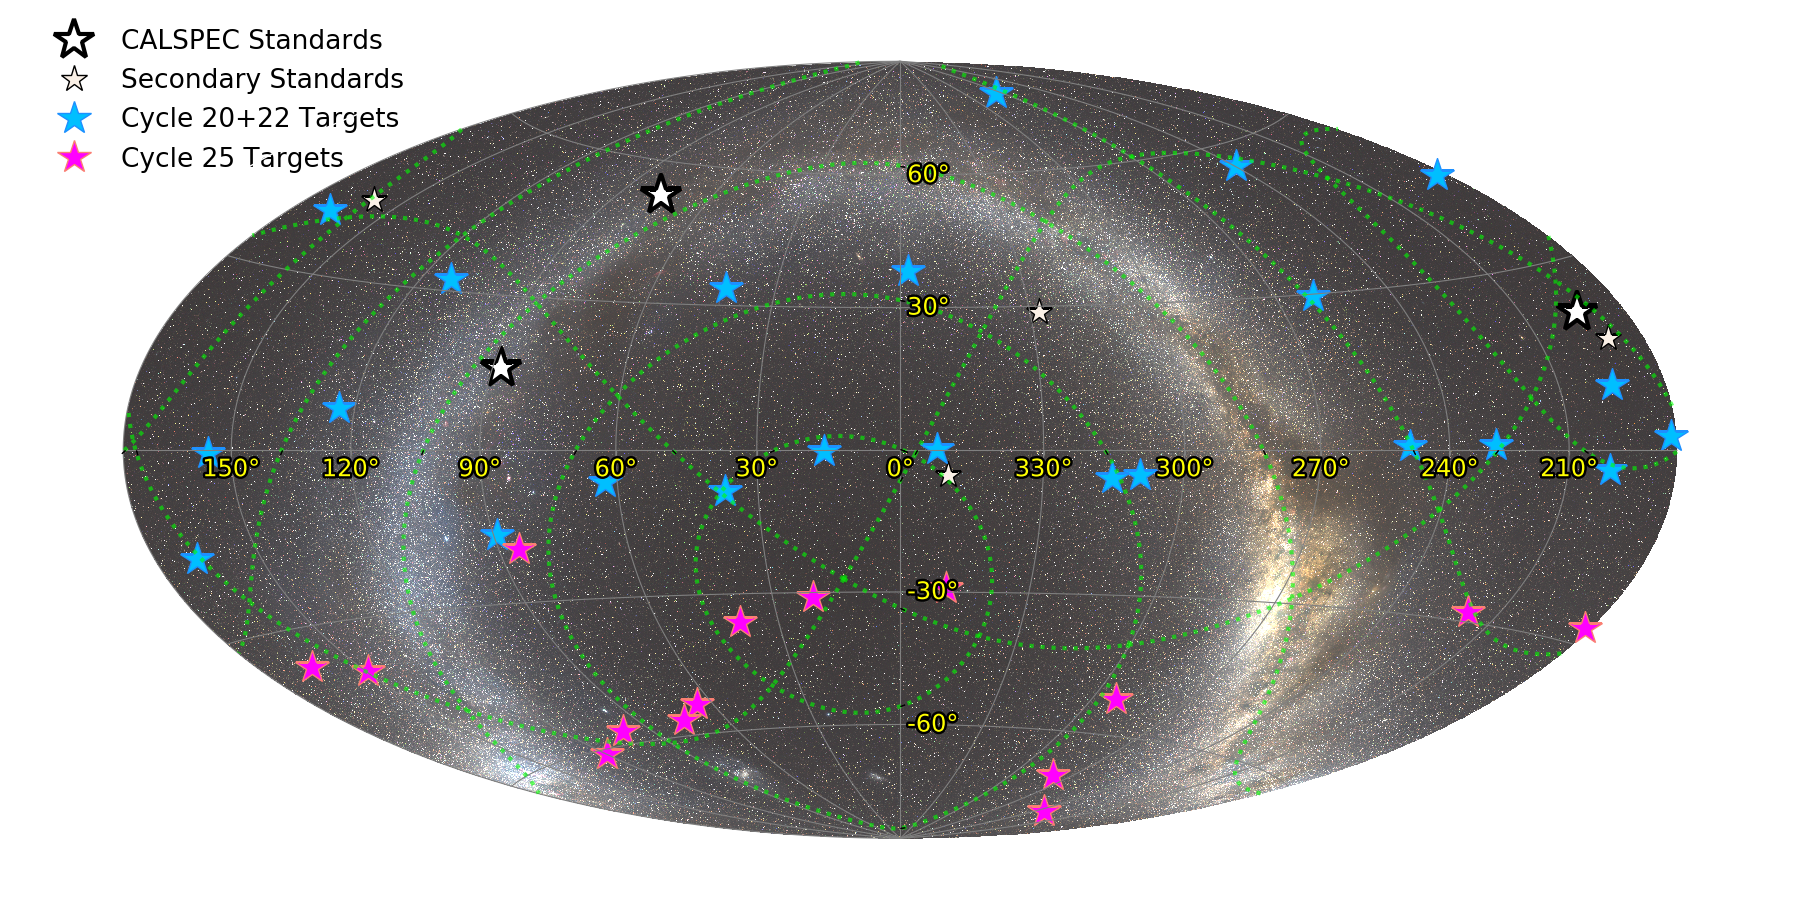

/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:641: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:641: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:524: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py:524: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/gnarayan/anaconda3/envs/dsfp5/lib/python3.6/site-packages/astropy/coordinates/angles.py

In [10]:
fig = plt.figure(figsize=(18,9))
# note how we're supplying a WCS as the projection to matplotlib
# also note that this plot is going to have an elliptical frame
ax3 = fig.add_subplot(111, projection=targetwcs, frame_class=frame.EllipticalFrame)

# display the image
im = ax3.imshow(z2, origin='lower', alpha=0.8)

# add a grey grid for what whatever we're using as the native projection
ax3.coords.grid(color='grey', ls='solid')

# we're going to plot our targets as stars, but we'd like to make them stand out, so we'll add a path effect
path_effects=[matplotlib.patheffects.withStroke(linewidth=3.5, foreground='black')]

if output_ctype == 'galactic':

    # configure the axes ticks
    ax3.coords['glat'].set_ticks(spacing=30 * u.degree, color='grey', exclude_overlapping=True)
    ax3.coords['glon'].set_ticks(spacing=30 * u.degree, color='grey', exclude_overlapping=True)
    ax3.coords['glon'].set_ticklabel(color='lime', path_effects=path_effects, fontsize='xx-large')
    ax3.coords['glat'].set_ticklabel_position('v')
    ax3.coords['glat'].set_ticklabel(color='lime', path_effects=path_effects, fontsize='xx-large')

    # create an Equatorial Grid (FK5 is implicitly epoch J2000)
    overlay = ax3.get_coords_overlay('fk5')
    overlay.grid(color='yellow', ls='dotted',lw=3, alpha=0.6)

    # plot the stars
    ax3.plot(l[calspec], b[calspec], marker='*', transform=ax3.get_transform('galactic'), color='white',\
         linestyle='None', mec='black', mew=3, markersize=30, label='CALSPEC Standards')
    ax3.plot(l[secondary], b[secondary], marker='*', transform=ax3.get_transform('galactic'), color='linen',\
         linestyle='None', mec='black', markersize=20, label='Secondary Standards')
    ax3.plot(l[c22], b[c22], marker='*', transform=ax3.get_transform('galactic'), color='deepskyblue',\
         linestyle='None', mec='dodgerblue', markersize=25, label='Cycle 20+22 Targets')
    ax3.plot(l[c25], b[c25], marker='*', transform=ax3.get_transform('galactic'), color='fuchsia',\
         linestyle='None', mec='salmon', markersize=25, label='Cycle 25 Targets')

    # add a legend
    ax3.legend(ncol=1, frameon=False, mode="expand", borderaxespad=0., fontsize=19, loc='upper left')

else:
    # same as above but for equatorial coordinates, we use RA, Dec, and our grid is in galactic coordinates
    ax3.coords['ra'].set_ticks(spacing=30 * u.degree, color='grey', exclude_overlapping=True)
    ax3.coords['dec'].set_ticks(spacing=30 * u.degree, color='grey', exclude_overlapping=True)
    ax3.coords['ra'].set_ticklabel(color='yellow', path_effects=path_effects, fontsize='xx-large')
    ax3.coords['dec'].set_ticklabel_position('v')
    ax3.coords['dec'].set_ticklabel(color='yellow', path_effects=path_effects, fontsize='xx-large')

    overlay = ax3.get_coords_overlay('galactic')
    overlay.grid(color='lime', ls='dotted',lw=3, alpha=0.6)

    ax3.plot(ra[calspec], dec[calspec], marker='*', transform=ax3.get_transform('fk5'), color='white',\
         linestyle='None', mec='black', mew=3, markersize=30, label='CALSPEC Standards')
    ax3.plot(ra[secondary], dec[secondary], marker='*', transform=ax3.get_transform('fk5'), color='linen',\
         linestyle='None', mec='black', markersize=20, label='Secondary Standards')
    ax3.plot(ra[c22], dec[c22], marker='*', transform=ax3.get_transform('fk5'), color='deepskyblue',\
         linestyle='None', mec='dodgerblue', markersize=25, label='Cycle 20+22 Targets')
    ax3.plot(ra[c25], dec[c25], marker='*', transform=ax3.get_transform('fk5'), color='fuchsia',\
         linestyle='None', mec='salmon', markersize=25, label='Cycle 25 Targets')
    
    ax3.legend(ncol=1, frameon=False, mode="expand", borderaxespad=0., fontsize=19, loc='upper left')

plt.tight_layout()
im.set_clip_path(ax3.coords.frame.patch)
ax3.coords.frame.set_color('white')

# save the image
savefig('allsky_{}.pdf'.format(output_ctype))